In [2]:
import hipscat
import healpy as hp
import pandas as pd
from tqdm import tqdm
from hipscat.inspection import plot_pixel_list
from hipscat.pixel_math import HealpixPixel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

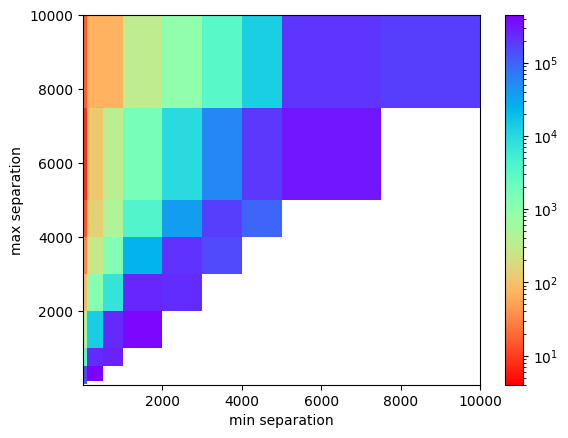

In [14]:
big_beautiful_frame = pd.read_csv("bbf.csv")

# sep_bins = [1, 10, 100, 1_000, 10_000, 50_000, 155_000]
# sep_bins = [1, 10, 100, 1_000, 10_000, 20_000, 30_000, 40_000, 50_000, 75_000]
sep_bins = [1, 10, 100, 500, 1_000, 2_000, 3_000, 4_000, 5_000, 7_500, 10_000]

H, xedges, yedges = np.histogram2d(big_beautiful_frame["min_sep"], 
                                   big_beautiful_frame["max_sep"],
                                   bins=(sep_bins, sep_bins))
H = H.T

fig, ax = plt.subplots()
X, Y = np.meshgrid(xedges, yedges)
pc = ax.pcolormesh(X, Y, H, shading='flat', cmap="rainbow_r", norm="log")
ax.set_title("")
ax.set_xlabel('min separation')
ax.set_ylabel('max separation')
# ax.set_yscale('log')
# ax.set_yscale('log')
fig.colorbar(pc)
plt.show()

In [15]:
big_beautiful_frame["max_sep"].max()

154558.46597361984

In [19]:
sep_bins = [1, 10, 100, 500, 1_000, 2_000, 3_000, 4_000, 5_000, 7_500, 10_000, 20_000, 30_000, 40_000, 50_000,100_000, 155_000]
# len(sep_bins)

right = np.searchsorted(sep_bins, big_beautiful_frame["min_sep"])
left = np.searchsorted(sep_bins, big_beautiful_frame["max_sep"])
span = left - right + 1
span[0:10]

array([5, 6, 3, 4, 2, 2, 3, 2, 3, 3])

In [24]:
bin_hist, bin_bins = np.histogram(span, bins = np.arange(1, 19))

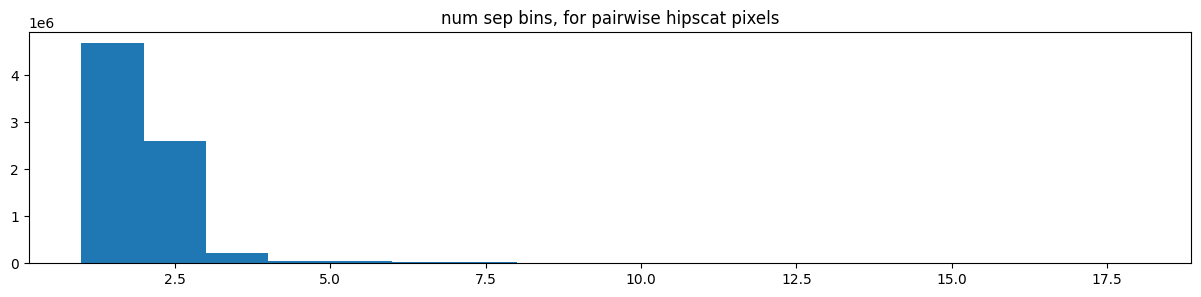

In [28]:
width = np.diff(bin_bins)
center = (bin_bins[:-1] + bin_bins[1:]) / 2

fig, ax = plt.subplots(figsize=(15,3))
ax.bar(center, bin_hist, align='center', width=width)
# ax.set_yscale('log')
plt.title(f"num sep bins, for pairwise hipscat pixels")
plt.show()

In [32]:
bin_hist

array([4680685, 2606439,  223729,   43134,   55660,   36807,   31794,
         12031,    9324,    8515,    4957,    7110,    5777,    7190,
          2282,     378,     399])

In [37]:
num_pairs = np.sum(bin_hist)
proportion = bin_hist / num_pairs

In [44]:
proportion

array([6.05035850e-01, 3.36914156e-01, 2.89197128e-02, 5.57559767e-03,
       7.19473654e-03, 4.75775544e-03, 4.10976381e-03, 1.55515407e-03,
       1.20524117e-03, 1.10066801e-03, 6.40752947e-04, 9.19054560e-04,
       7.46747988e-04, 9.29395540e-04, 2.94976443e-04, 4.88611285e-05,
       5.15756357e-05])

60% of tile pairs will have only one possible separation bin. As a result, we only need the total masked count for these tile-pairs.


33% will have two possible bins. Once pair separations have been determined, the binning clause can be quickly short-circuited. We will know BEFORE loading the parquet tiles into memory what the possible bins are. Can pass just the dividing line between bins to counting routine! Could just return `count sep less than X`.

< 3% will have three possible bins.

Remaining 3% of tile pairs have 4+ possible bins. These are the smallest separations, and the ones that we will spend the most time on (and where we SHOULD be spending the most time getting the counts right!
)

In [43]:
long_tail_tile_pairs = np.sum(bin_hist[3:])
long_tail_tile_pairs / np.sum(bin_hist)

0.0291302809605374